In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline
from datetime import datetime, timedelta
from scipy import stats
from matplotlib.lines import Line2D
import geopandas

import glob

import sys
sys.path.append('../')
import plotting
import utils

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data

In [2]:
ds = xr.open_zarr('./model_NEI_egrid_GC_ds.zarr')

In [3]:
utils.lat_lon_dict['US_lat_lon']

[-130.0, -60.0, 24.0, 45.0]

### Import Dataframes of Interpolated and EPA Data

In [4]:
interp_df = pd.read_csv('./interp_df.csv', parse_dates = True)
EPA_obs_df = pd.read_csv('./EPA_obs_df.csv', parse_dates = True)
EPA_monthly_df = pd.read_csv('./EPA_monthly_obs_df.csv', parse_dates = True)
interp_df['date'] = pd.to_datetime(interp_df['date'])
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['date'], format='%Y%m%d')
EPA_monthly_df['date'] = pd.to_datetime(EPA_monthly_df['date'], format = '%Y%m%d')

EPA_obs_df = EPA_obs_df.loc[(EPA_obs_df['Latitude'].between(24,50,inclusive = True)) & (EPA_obs_df['Longitude'].between(-130,-60,inclusive = True))]
EPA_monthly_df = EPA_monthly_df.loc[(EPA_monthly_df['latitude'].between(24,50,inclusive = True)) & (EPA_monthly_df['longitude'].between(-130,-60,inclusive = True))]
interp_df = interp_df.loc[(interp_df['Latitude'].between(24,50,inclusive = True)) & (interp_df['Longitude'].between(-130,-60,inclusive = True))]



### Lists/Dicts of Variables

In [5]:
#define Lat and Lon of the nested grid US
model_names = ['egrid','NEI','MODEL']

levels_dict = {'PM25':np.arange(0., 51, 1), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}
colors_dict = {'egrid':'xkcd:scarlet', 'NEI':'xkcd:bluish','MODEL':'xkcd:forest green'}

### Dictionary of Differences between Interpolation and Observations

In [6]:
EPA_interp_dif = utils.interp_obs_differences(EPA_obs_df, interp_df, utils.month_string, model_names)

# Plots 

In [7]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_string = utils.month_string
cmap_conc = 'pink_r'
cmap_dif = 'BrBG_r'


### Differences between Observations and each GC Run

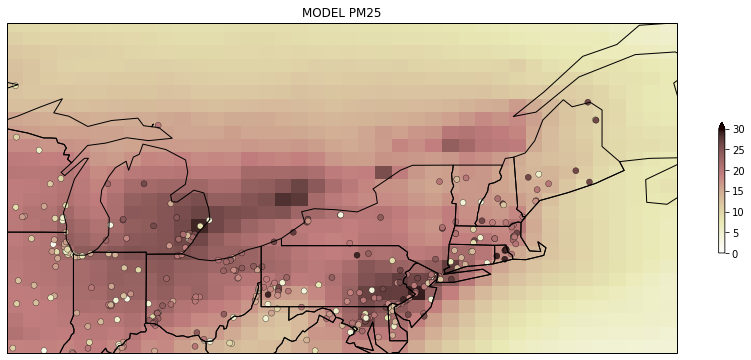

In [18]:
plotting.obs_model_plot(ds, interp_df.loc[interp_df['model'] == 'MODEL'], species = 'PM25',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = months,
               vmin = 0, vmax = 30, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])

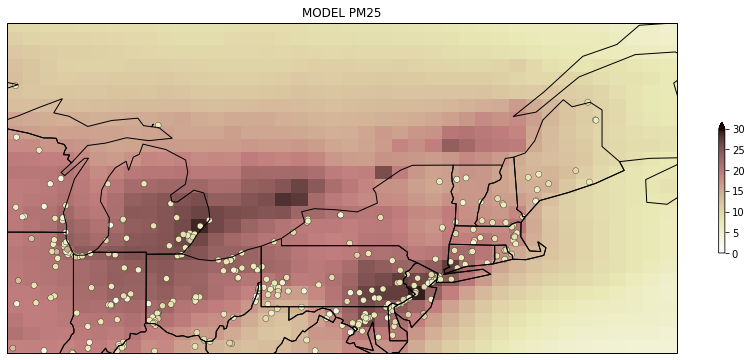

In [19]:
plotting.obs_model_plot(ds, EPA_obs_df, species = 'PM25',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = months,
               vmin = 0, vmax = 30, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])
#plt.annotate(s = 'NEI, Egrid, and EGO Model vs. EPA Observation PM25 Concentrations', xy = (0.3,0.85), xycoords = 'figure fraction', fontsize = 16);

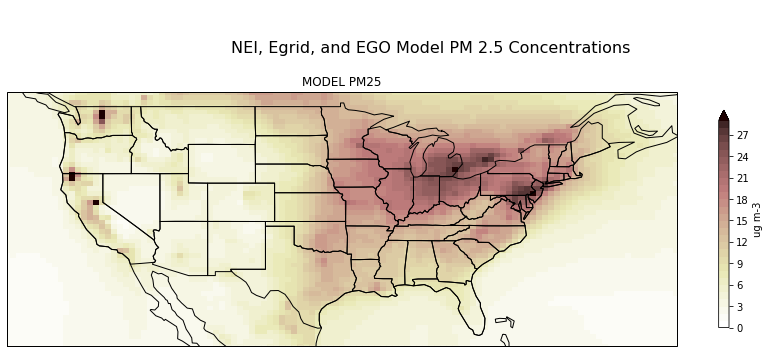

In [16]:
plotting.concentration_plot(ds, species = 'PM25', model_names = ['MODEL'],
                   rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['US_lat_lon'],
                    levels = np.arange(0,30,1),figsize = [15,8], cmap = cmap_conc, shrink_cbar = .5)
plt.annotate(s = 'NEI, Egrid, and EGO Model PM 2.5 Concentrations', xy = (0.3,0.85), xycoords = 'figure fraction', fontsize = 16);

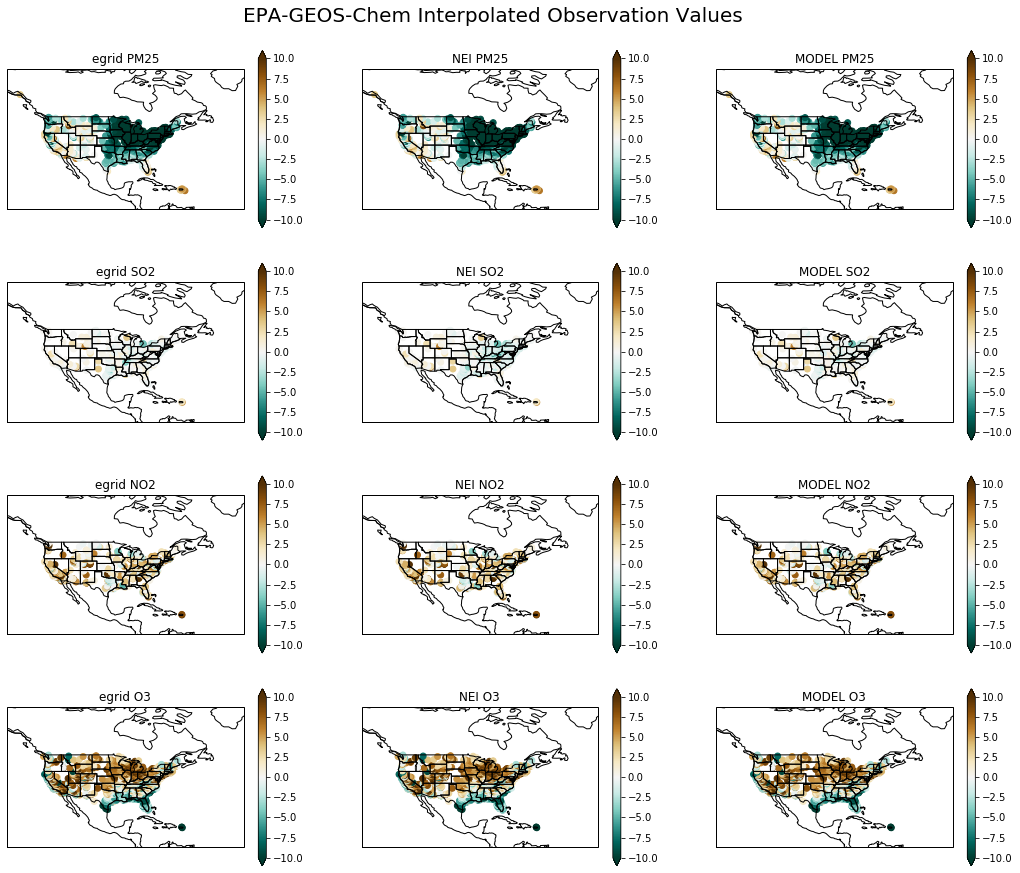

In [144]:
fig, axes = plt.subplots(4,3,figsize = [18,15],subplot_kw={'projection': ccrs.PlateCarree()})
for idx_s, species in enumerate(['PM25', 'SO2', 'NO2', 'O3']):
    for idx_m, model in enumerate(model_names):
        ax = axes[idx_s,idx_m] 
        lat_o = EPA_interp_dif[species][model].reset_index()['Latitude']
        lon_o = EPA_interp_dif[species][model].reset_index()['Longitude']
        c = EPA_interp_dif[species][model].reset_index()['Arithmetic Mean']
        PCM_o = ax.scatter(lon_o, lat_o, c = c, transform = ccrs.PlateCarree(), cmap = cmap_dif, vmin = -10, vmax = 10)
        plt.colorbar(PCM_o, ax=ax,extend='both', cmap = cmap_dif) 
        ax.coastlines()
        ax.add_feature(cfeat.STATES)
        ax.set_extent(utils.lat_lon_dict['US_lat_lon'])
        ax.set_title(f'{model} {species}')
plt.suptitle('EPA-GEOS-Chem Interpolated Observation Values', fontsize = 20, y = .92);

# Linear Regression and Scatterplots

## Scatterplots of interpolation

In [8]:
### linear regression on our data (EPA vs GC model runs)
lin_regress_df = utils.linregress_data(EPA_obs_df, interp_df, model_names, month_string)

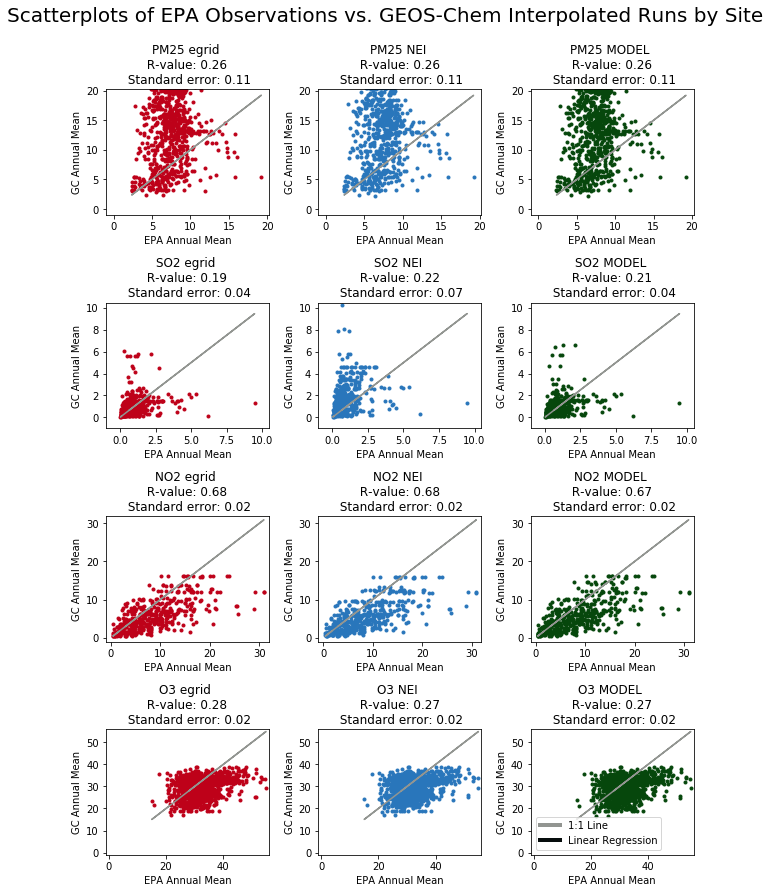

In [21]:
plotting.interp_scatterplot(interp_df, EPA_obs_df, lin_regress_df, model_names = model_names, month_string = month_string, colors_dict = colors_dict)
plt.suptitle('Scatterplots of EPA Observations vs. GEOS-Chem Interpolated Runs by Site', fontsize = 20, y = 1.03);

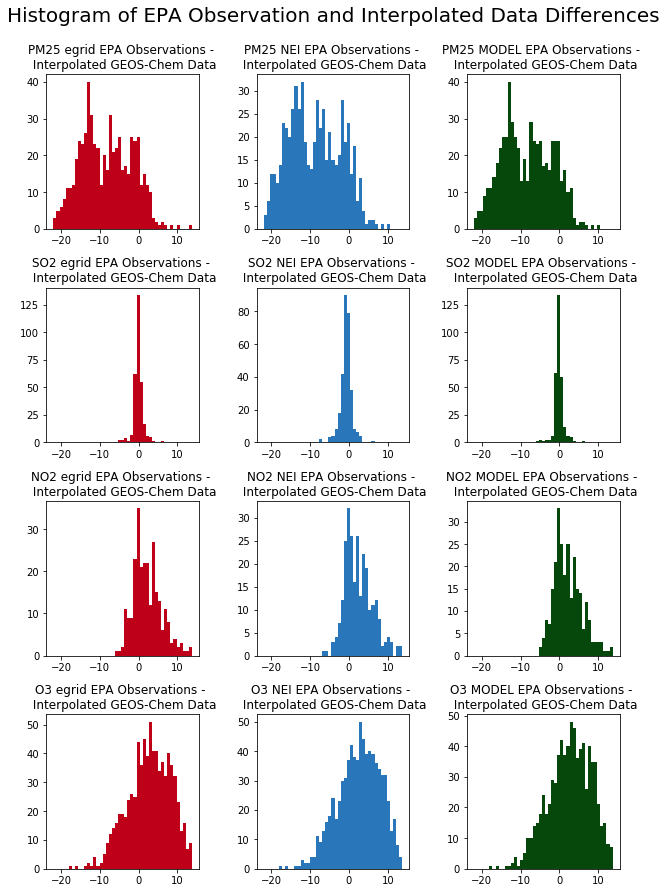

In [11]:
plotting.hist_obs_interp(EPA_interp_dif, model_names, colors_dict, bins = 45)
plt.suptitle('Histogram of EPA Observation and Interpolated Data Differences', fontsize = 20, y = 1.03);

## Group Dataframes by region and look at regional distribution of error

In [9]:
model = 'MODEL'
species = 'NO2'
boxplot_df = EPA_monthly_df.loc[
    (EPA_monthly_df['species'] == utils.species_dict[species])
]
boxplot_df2 = interp_df.loc[
    (interp_df['model'] == model) & (interp_df['species'] == utils.species_dict[species])
]

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


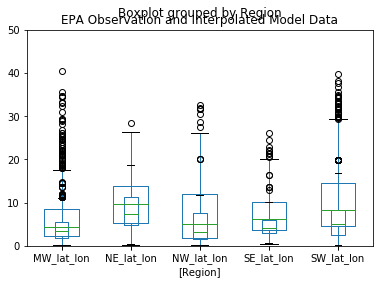

In [42]:
ax1 = boxplot_df.boxplot(column = ['Arithmetic Mean'], by = ['Region'], return_type = 'axes')
boxplot_df2.boxplot(column = ['Arithmetic Mean'], by = ['Region'], ax = ax1, grid = False)
plt.ylim(0,50);
plt.title('EPA Observation and Interpolated Model Data');